In [48]:
import networkx as nx
import random
import numpy as np
import time as time

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15,7]
#Girvan Newman Algorithm for edge removal
#Get components at every edge removal
#Finding the right cuts: Calc Modularity for every cut, when you get highest modularity, that's the community partition
# Highest peak == optimal partition
#A peak may be an interesting cut
#Time efficiency if BFS=O(|edges|)
# Edge betweeness O(|V||E|)
#Every time we remove an edge we have to recalculate edge betweeness O(|V|*|E|*|E|)


In [49]:
g = nx.read_edgelist("./Edgelists/complete_networld_cap.edgelist", create_using = nx.DiGraph())

In [50]:
g = nx.read_edgelist("./Edgelists/friedrichshain_center_dg_cap.edgelist", create_using = nx.DiGraph())

In [102]:
def random_walk(g):
    edge_count = {}
    n = len(g.nodes)
    for i in range(5000):
        start = str(np.random.randint(1,n))
        status = True
        while status == True:
            for j in range(1,9):
                node_neighbors = list(g.neighbors(start))
                if len(node_neighbors) != 0:
                    N = random.choice(list(g.neighbors(start)))
                    pair = start + ' ' + N

                    try: 
                        edge_count[pair] += 1
                    except KeyError as e:
                        edge_count[pair] = 1   
                    start = N

                else:
                    status = False
            status = False 
    return edge_count
            

In [103]:
def avg_list(alist):
    avg_list = [sum(elem)/len(elem) for elem in zip(*alist)]
    
    return avg_list

In [104]:
len(g.node())

224

In [105]:
def attributes(g):
    total_cars = 0
    edge_cap = nx.get_edge_attributes(g,'capacity')
    edge_cars = nx.get_edge_attributes(g,'cars')
    for i in edge_cars:
        total_cars += edge_cars[i]
    
    return total_cars, edge_cap, edge_cars
        

In [106]:
def res_test(edgelist, runs, redistribute, sort):
    
    g = nx.read_edgelist(edgelist, create_using = nx.DiGraph())
    avg_weak_comp, avg_strong_comp, avg_total_comp, avg_edge_removal_pct = [], [], [], []
    total_edges = len(g.edges)
    
    for run in range(runs):
        print("Run: ", run+1)
        
        g = nx.read_edgelist(edgelist, create_using = nx.DiGraph())
        
        if redistribute:
            total_cars, g_edge_cap, g_edge_cars = attributes(g)
            stuck_cars = 0
            alist = [(0,0)]
            new_list = [(0,stuck_cars)]
            
        
        edge_count = random_walk(g)
        
        if sort:
            edge_count = sorted(edge_count, key=edge_count.get, reverse=True)
        
        # nr. of weak, strong, weak+strong comp and pct. of edges removed from g
        total_comp, weak_comp, strong_comp, edge_removal_pct = [], [], [], []
        weak_comp.append(nx.number_weakly_connected_components(g))
        strong_comp.append(nx.number_strongly_connected_components(g))
        total_comp.append(weak_comp[0] + strong_comp[0])
        edge_removal_pct.append(0/len(g.edges())*100) #start of our list: is 0.0 as we haven't remove any edges
        total_edge_count = len(g.edges())

        for index, elem in enumerate(edge_count):
            elem = elem.split(' ')
            start_node = elem[0]
            end_node = elem[1]
            
            if g.has_edge(start_node, end_node):
                g.remove_edge(start_node,end_node)
            else:
                stuck_cars += g_edge_cars[start_node,end_node]
                removed_edges = total_edges-len(g.edges)
                alist.append((removed_edges,stuck_cars))
                continue
            
            #The redistribution attempts to add the cars of the edge we just removed to the starting node's other edges, 
            #if it has any and only if they have a path to the end node. 
            
            if redistribute:
                cars = g_edge_cars[start_node,end_node]
                start_node_neighbors = g.successors(start_node) #list of the neighbors of our starting node
                neighbors_w_path = {}

                for successor in start_node_neighbors:
                    have_path = nx.has_path(g, successor, end_node) #return True if there is a path from successor to end_node
                    if have_path:
                        #add the neighboring node as the key with (start_node, itself) as the val, representing the edge betwn them.
                        neighbors_w_path[successor] = start_node, successor 
                    else:
                        continue

                if len(neighbors_w_path) != 0:
                    cars_frac = cars/len(neighbors_w_path) #divide the cars equally among the edges with a path to the end node
                    fail_set = set()
                    stuck_cars, alist, new_list = redistribute_cars(g,start_node, cars_frac, neighbors_w_path,g_edge_cars, g_edge_cap, fail_set, stuck_cars, alist, total_edges, new_list)

                else:
                    stuck_cars += cars #no path to the end node, the cars are thus stuck
                    removed_edges = total_edges-len(g.edges)
                    alist.append((removed_edges,stuck_cars))
                    new_list.append((new_list[-1][0],new_list[-1][1]+cars))
            
            if index % 1 == 0:

                weakly_comp = nx.number_weakly_connected_components(g)
                strongly_comp = nx.number_strongly_connected_components(g)

                total_comp.append(weakly_comp + strongly_comp)
                weak_comp.append(weakly_comp)
                strong_comp.append(strongly_comp)

                edge_removal_pct_value = index/total_edge_count * 100
                edge_removal_pct.append(edge_removal_pct_value)

        avg_weak_comp.append(weak_comp)
        avg_strong_comp.append(strong_comp)
        avg_total_comp.append(total_comp)
        avg_edge_removal_pct.append(edge_removal_pct)

    final_weak = avg_list(avg_weak_comp)
    final_strong =  avg_list(avg_strong_comp)
    final_total = avg_list(avg_total_comp)
    final_percentage = avg_list(avg_edge_removal_pct)
    
    plt.plot(final_percentage, final_weak, label="weak")
    plt.plot(final_percentage, final_strong, label="strong")
    plt.plot(final_percentage, final_total, label="total")
    plt.xlabel('Edge Removal Percentage')
    plt.ylabel('Number of Components')
    plt.legend()
    plt.show()
    plt.close()
    
    return stuck_cars, alist, removed_edges, new_list

In [107]:
def redistribute_cars(g,start_node, cars_frac, neighbor_w_path, g_edge_cars, g_edge_cap, fail_set, stuck_cars, alist, total_edges, new_list):
    new_list.append((new_list[-1][0]+1,new_list[-1][1]))
    for successor in neighbor_w_path:
        end_node = neighbor_w_path[successor][1]
        if g_edge_cars[start_node, end_node] + cars_frac > g_edge_cap[start_node,end_node]:
            if successor in fail_set:
                continue
            else:
                fail_set.add(successor)
                
                if len(fail_set) != len(neighbor_w_path):
                    extra_cars = cars_frac/(len(neighbor_w_path)-len(fail_set))
                    g.remove_edge(start_node,end_node)
                    removed_edges = total_edges - len(g.edges)
                    alist.append((removed_edges,stuck_cars))
                    stuck_cars, alist, new_list = redistribute_cars(g,start_node, extra_cars, neighbor_w_path, g_edge_cars, g_edge_cap, fail_set, stuck_cars, alist,total_edges, new_list)
                else:
                    stuck_cars += cars_frac
                    removed_edges = total_edges - len(g.edges) 
                    alist.append((removed_edges, stuck_cars))
                    new_list.append((new_list[-1][0],new_list[-1][1]+cars_frac))
        else:
            g_edge_cars[start_node,end_node] += cars_frac
        
    return stuck_cars, alist, new_list

Run:  1


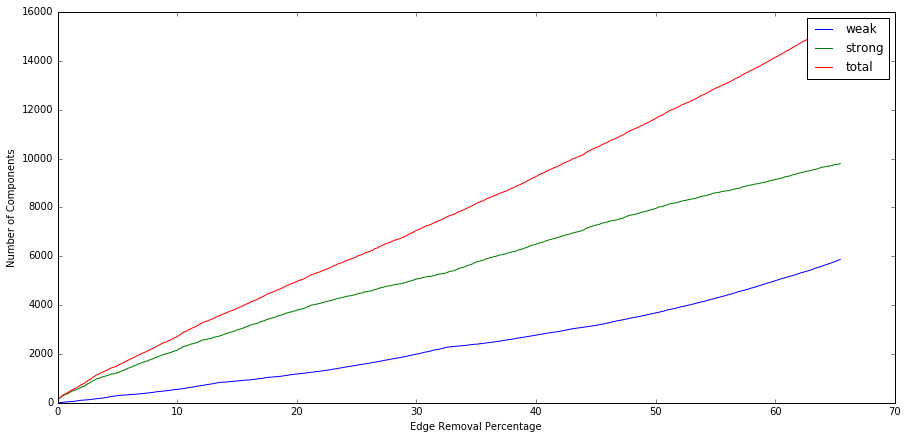

2602.0606474876404


In [109]:
start = time.time()
stuck_cars, alist, removed_edges, new_list  = res_test("./Edgelists/complete_networld_cap.edgelist", runs=1, redistribute=True, sort=True)
end = time.time() - start
print(end)

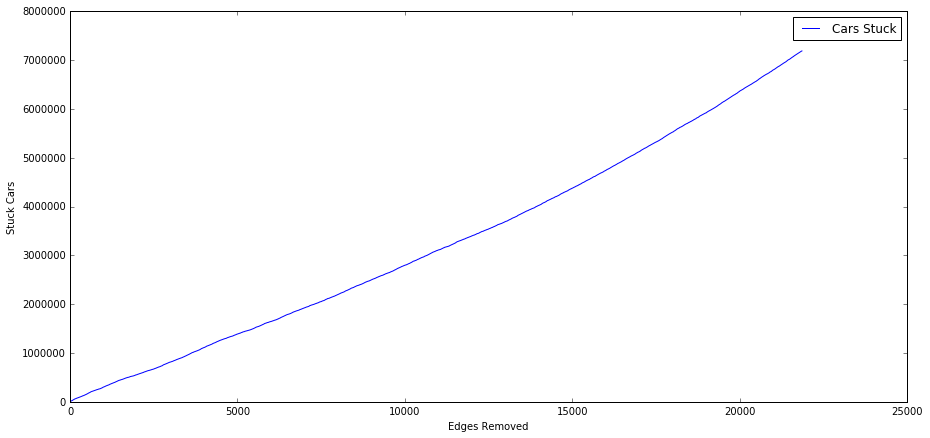

In [111]:
removed_list = []
stuck_list = []
for i in range(len(alist)):
    removed_list.append(alist[i][0])
    stuck_list.append(alist[i][1])
plt.plot(removed_list,stuck_list, label="Cars Stuck")
plt.xlabel("Edges Removed")
plt.ylabel("Stuck Cars")
plt.legend()
plt.show()
plt.close()

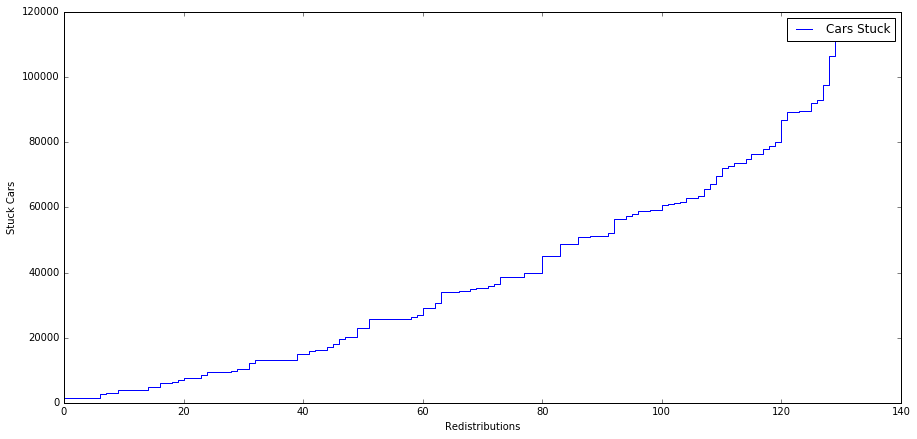

In [95]:
redistributions = []
stuck_list = []
for i in range(len(new_list)):
    redistributions.append(new_list[i][0])
    stuck_list.append(new_list[i][1])
plt.plot(redistributions,stuck_list,label="Cars Stuck")
plt.xlabel("Redistributions")
plt.ylabel("Stuck Cars")
plt.legend()
plt.show()
plt.close()

In [ ]:
for i in alist:
    print(i)

In [ ]:
complete_networld_cap.edgelist

In [ ]:
g = nx.read_edgelist("complete_networld_cap.edgelist", create_using = nx.DiGraph())

In [ ]:
res_test(g, runs=1, redistribute=False, sort=False, extra_walks=False)

In [ ]:
G = nx.Graph()

In [ ]:
G.add_nodes_from([2,3])
G.add_nodes_from(range(100,110))
H=nx.Graph()
H.add_path([0,1,2,3,4,5,6,7,8,9])
G.add_nodes_from(H)

In [ ]:
G.nodes()
G.add_edges_from([(1,2),(1,3)])

In [ ]:
G.edges()

In [ ]:
x = 2
def remove(G, x):
    G.nodes()
    G.remove_edge(1,2)
    print(G.edges())
    x += 1
    print(x)
remove(G, x)
print(x)

In [ ]:
G.edges

In [ ]:
x = [1,2,3]
plt.plot(x)
plt.show()
plt.close()